# 02.01 Geospatial Analysis: Neighborhood Council Only Visualizations
## Issue 1279
[Shapefile Source - City of LA](https://data.lacity.org/City-Infrastructure-Service-Requests/Neighborhood-Councils-Certified-/fu65-dz2f)

---

# Table of Contents
---
## [Package & Data Imports  ](#Package-&-Data-Imports)
## [Neighborhood Council Choropleth  ](#Neighborhood-Council-Choropleth)
## [Type of Request by Neighborhood Council Layered Choropleths  ](#Type-of-Request-by-Neighborhood-Council-Layered-Choropleths)

# Package & Data Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# https://stackoverflow.com/questions/13440102/getting-bounding-box-of-city
import geopandas as gpd

%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [2]:
# 311 Data 10/01/2021-10/01/2022 from API see 01 notebook
raw_df = pd.read_csv('../data/clean_01Oct21_01Oct22_api.csv')
df = raw_df.copy()

# https://geopandas.org/en/stable/getting_started/introduction.html
# NC boundaries: https://data.lacity.org/City-Infrastructure-Service-Requests/Neighborhood-Councils-Certified-/fu65-dz2f
raw_gdf_nc = gpd.read_file('../data/Neighborhood Councils (Certified)/geo_export_88bb18d9-f96c-4351-8be9-594f258ed0d3.shp')
gdf_nc = raw_gdf_nc.copy()

# Block boundaries: https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/06_CALIFORNIA/06037/
# tl_2020_06037_tabblock20.zip
raw_gdf_blk = gpd.read_file("../data/tl_2020_06037_tabblock20/tl_2020_06037_tabblock20.shp")
gdf_blk = raw_gdf_blk.copy()

# merged nc and blk geodata
gdf_blk_nc_raw = pd.read_csv('../data/clean_01Oct21_01Oct22_nc_blk.csv')
gdf_blk_nc = gdf_blk_nc_raw.copy()

# merged request dataset with nc block geodata
gdf_blk_nc_raw = pd.read_csv('../data/clean_01Oct21_01Oct22_nc_blk_req.csv')
gdf_blk_nc = gdf_blk_nc_raw.copy()

# Neighborhood Council Choropleth
---

In [3]:
# create groupby neighborhood council
df_nc_ct = df.groupby('councilName')['councilId'].value_counts().reset_index(name = 'count')
print(df_nc_ct.shape)
df_nc_ct.head()

(100, 3)


councilName  councilId  count
0                 Arleta          1  10556
1            Arroyo Seco          2   4857
2        Atwater Village          3   4300
3  Bel Air-Beverly Crest          4   4622
4          Boyle Heights          5  30823

In [4]:
# merge NC grouping with geometries
gdf_nc_plt = pd.merge(gdf_nc, df_nc_ct, how = 'left', left_on = 'objectid', right_on = 'councilId')
gdf_nc_plt.drop(columns = 'objectid', inplace = True)

# incase need to minimize dataset for testing
# gdf_nc_plt = gdf_nc_plt.sample(frac = .01, random_state = 42)

# sort and remove unnecessary columns
gdf_nc_plt = gdf_nc_plt.sort_values(by = 'councilId').reset_index(drop = True)
gdf_nc_plt = gdf_nc_plt[['geometry', 'councilId', 'councilName', 'count']]

# put geometry in format for folium
gdf_nc_plt = gdf_nc_plt.to_crs(epsg=4326)

# check geodataframe
print(gdf_nc_plt.shape)
gdf_nc_plt.head()

(99, 4)


geometry  councilId  \
0  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1   
1  POLYGON ((-118.22325 34.10393, -118.22367 34.1...          2   
2  POLYGON ((-118.27576 34.15376, -118.26184 34.1...          3   
3  POLYGON ((-118.47485 34.12634, -118.47411 34.1...          4   
4  POLYGON ((-118.21439 34.06063, -118.21303 34.0...          5   

             councilName  count  
0                 Arleta  10556  
1            Arroyo Seco   4857  
2        Atwater Village   4300  
3  Bel Air-Beverly Crest   4622  
4          Boyle Heights  30823

In [5]:
# check top count to compare to mapping
gdf_nc_plt.sort_values(by = 'count', ascending = False).head()

geometry  councilId  \
4   POLYGON ((-118.21439 34.06063, -118.21303 34.0...          5   
78  POLYGON ((-118.50737 34.33461, -118.50380 34.3...         79   
20  POLYGON ((-118.29167 33.96665, -118.28269 33.9...         21   
73  POLYGON ((-118.23952 34.00796, -118.24324 34.0...         74   
82  POLYGON ((-118.47324 34.21651, -118.42666 34.2...         83   

                       councilName  count  
4                    Boyle Heights  30823  
78                          Sylmar  24437  
20  Empowerment Congress Southeast  24252  
73                   South Central  23714  
82                        Van Nuys  22802

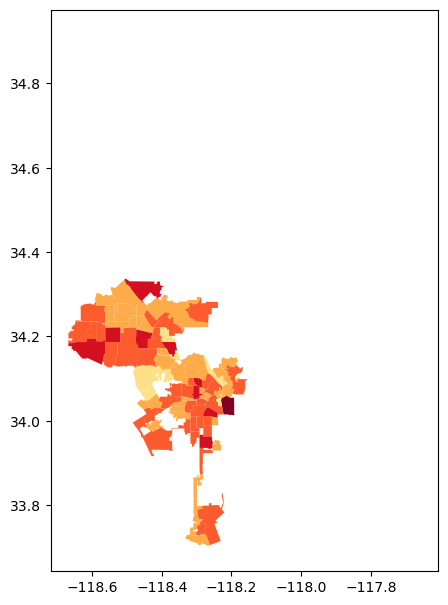

In [6]:
# basic geopandas plot for comparison to folium
gdf_nc_plt.plot(column = 'count', scheme='percentiles', cmap='YlOrRd', figsize = (5, 10));

In [7]:
# https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html

# basemap
fig = Figure(height = 600, width = 1000)
nc_map = folium.Map(location = (34.03, -118.39), tiles='cartodbpositron', zoom_start=9.5)
fig.add_child(nc_map)

# neighborhood council requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc = folium.Choropleth(
    geo_data = gdf_nc_plt.to_json(),
    name="NC choropleth",
    data = gdf_nc_plt,
    columns=['councilName', 'count'],
    key_on="feature.properties.councilName",
    fill_color="YlGn",
    fill_opacity=0.7,
    nan_fill_opacity = 0,
    line_opacity=0.5,
    legend_name="311 Requests per Neighborhood Council",
)

nc_map.add_child(choro_nc)

# NC tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'count'],
    aliases = ['Neighborhood Council', 'Council ID', '# of Requests'],
    localize = True
))


folium.LayerControl().add_to(nc_map)

nc_map

# Type of Request by Neighborhood Council Layered Choropleths
---

In [8]:
# create groupby neighborhood council
df_nc_type_ct = df.groupby(['councilName', 'councilId', 'typeName'])['typeId'].value_counts().reset_index(name = 'type_count')
print(df_nc_type_ct.shape)
df_nc_type_ct.head()

(1172, 5)


councilName  councilId          typeName  typeId  type_count
0      Arleta          1    Animal Remains       3         320
1      Arleta          1       Bulky Items       4        5621
2      Arleta          1  Electronic Waste       5         394
3      Arleta          1          Feedback      12           2
4      Arleta          1          Graffiti       1        1272

In [9]:
# merge NC grouping with geometries
gdf_nc_type_plt = pd.merge(gdf_nc, df_nc_type_ct, how = 'left', left_on = 'objectid', right_on = 'councilId')
gdf_nc_type_plt.drop(columns = 'objectid', inplace = True)

# incase need to minimize dataset for testing
# gdf_nc_type_plt = gdf_nc_type_plt.sample(frac = .01, random_state = 42)

# sort and remove unnecessary columns
gdf_nc_type_plt = gdf_nc_type_plt.sort_values(by = 'councilId').reset_index(drop = True)
gdf_nc_type_plt = gdf_nc_type_plt[['geometry', 'councilId', 'councilName', 'typeName', 'type_count']]

# put geometry in format for folium
gdf_nc_type_plt = gdf_nc_type_plt.to_crs(epsg=4326)

# check geodataframe
print(gdf_nc_type_plt.shape)
gdf_nc_type_plt.head()

(1160, 5)


geometry  councilId councilName  \
0  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1      Arleta   
1  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1      Arleta   
2  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1      Arleta   
3  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1      Arleta   
4  POLYGON ((-118.45005 34.24992, -118.45055 34.2...          1      Arleta   

             typeName  type_count  
0      Animal Remains         320  
1         Water Waste           7  
2  Single Streetlight         142  
3               Other         155  
4    Metal/Appliances         804

In [10]:
sorted(gdf_nc_type_plt['typeName'].unique())

['Animal Remains',
 'Bulky Items',
 'Electronic Waste',
 'Feedback',
 'Graffiti',
 'Homeless Encampment',
 'Illegal Dumping',
 'Metal/Appliances',
 'Multiple Streetlights',
 'Other',
 'Single Streetlight',
 'Water Waste']

In [19]:
# https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html

# basemap
fig = Figure(height = 850, width = 1050)
nc_type_map = folium.Map(location = (34.2, -118.39), tiles='cartodbpositron', zoom_start=9.5)
fig.add_child(nc_type_map)
	
folium.TileLayer('openstreetmap').add_to(nc_type_map)


##### ANIMAL REMAINS
# Animal Remains requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_AR = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Animal Remains'].to_json(),
    name="Animal Remains",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Animal Remains'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="YlGn",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Animal Remains",
    show = False
)

nc_type_map.add_child(choro_nc_AR)


##### BULKY ITEMS
# Bulky Items requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_BI = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Bulky Items'].to_json(),
    name="Bulky Items",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Bulky Items'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="OrRd",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Bulky Items",
    show = False
)

nc_type_map.add_child(choro_nc_BI)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_BI.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_AR.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### ELECTRONIC WASTE
# Electronic Waste requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_EW = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Electronic Waste'].to_json(),
    name="Electronic Waste",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Electronic Waste'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="PuBuGn",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Electronic Waste",
    show = False
)

nc_type_map.add_child(choro_nc_EW)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_EW.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### FEEDBACK
# Feedback requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_F = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Feedback'].to_json(),
    name="Feedback",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Feedback'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="PuRd",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Feedback",
    show = False
)

nc_type_map.add_child(choro_nc_F)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_F.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### GRAFFITI
# Graffiti requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_G = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Graffiti'].to_json(),
    name="Graffiti",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Graffiti'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="YlGnBu",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Graffiti",
    show = False
)

nc_type_map.add_child(choro_nc_G)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_G.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### HOMELESS ENCAMPMENT
# Homeless Encampment requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_HE = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Homeless Encampment'].to_json(),
    name="Homeless Encampment",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Homeless Encampment'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="YlOrRd",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Homeless Encampment",
    show = False
)

nc_type_map.add_child(choro_nc_HE)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_HE.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### ILLEGAL DUMPING
# Illegal Dumping requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_ID = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Illegal Dumping'].to_json(),
    name="Illegal Dumping",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Illegal Dumping'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="RdPu",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Illegal Dumping",
    show = False
)

nc_type_map.add_child(choro_nc_ID)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_ID.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))

##### METAL / APPLIANCES
# Metal / Appliances requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_MA = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Metal/Appliances'].to_json(),
    name="Metal/Appliances",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Metal/Appliances'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="Purples",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Metal/Appliances",
    show = False
)

nc_type_map.add_child(choro_nc_MA)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_MA.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))

##### MULTIPLE STREETLIGHTS
# Multiple Streetlights requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_MS = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Multiple Streetlights'].to_json(),
    name="Multiple Streetlights",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Multiple Streetlights'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="Greens",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Multiple Streetlights",
    show = False
)

nc_type_map.add_child(choro_nc_MS)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_MS.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))

##### OTHER
# Other requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_O = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Other'].to_json(),
    name="Other",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Other'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="Greys",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Other",
    show = False
)

nc_type_map.add_child(choro_nc_O)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_O.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))

##### SINGLE STREET LIGHT
# Single Streetlight requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_SS = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Single Streetlight'].to_json(),
    name="Single Streetlight",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Single Streetlight'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="GnBu",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Single Streetlight",
    show = False
)

nc_type_map.add_child(choro_nc_SS)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_SS.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


##### WATER WASTE
# Water Waste requests choropleth
# adapted from https://python-visualization.github.io/folium/quickstart.html
choro_nc_WW = folium.Choropleth(
    geo_data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Water Waste'].to_json(),
    name="Water Waste",
    data = gdf_nc_type_plt[gdf_nc_type_plt['typeName'] == 'Water Waste'],
    columns=['councilName', 'type_count'],
    key_on="feature.properties.councilName",
    fill_color="BuPu",
    fill_opacity=1,
    nan_fill_opacity = 0,
    line_opacity=0.2,
    legend_name="Water Waste",
    show = False
)

nc_type_map.add_child(choro_nc_WW)

# NC type tooltip
# adapted from https://stackoverflow.com/questions/61144877/currency-geojsontooltip-formatting-in-folium
choro_nc_WW.geojson.add_child(folium.features.GeoJsonTooltip(
    fields = ['councilName', 'councilId', 'typeName', 'type_count'],
    aliases = ['Neighborhood Council', 'Council ID', 'Type of Request', '# of Requests'],
    localize = True
))


# NC boundary lines
folium.GeoJson(data = gdf_nc["geometry"], name = 'NC Boundaries', control = False,
               style_function = lambda x:{
                   "color": "#000000",
                   "weight": 1,
                   "opacity": .5,
                   "fill": False
               }
              ).add_to(nc_type_map)

folium.LayerControl(collapsed = False).add_to(nc_type_map)

nc_type_map

In [18]:
# save type by nc
nc_type_map.save('../streamlit/nc_type_layered.html')

In [13]:
# list(df_dict.items())[1]